<a href="https://www.kaggle.com/code/mexwell/missing-value-handling-air-passengers?scriptVersionId=184378483" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<center>
    <img widht='300px' src='https://cdn-icons-png.flaticon.com/512/38/38785.png?w=1800&t=st=1684435095~exp=1684435695~hmac=d7b2b610f4938144ad0bf0fddb2af07d7d4c5af0ef57d7d70eab3efe6515c3a5'>
    
# Missing value handling - Air Passengers - LightGBM Regression
</center>

Missing value handling for time series forecasting is crucial for several reasons:

- **Accurate forecasting:** Time series data often exhibits patterns and dependencies over time. Missing values disrupt this continuity and can lead to inaccurate forecasts if not properly handled. By addressing missing values, we can ensure that the underlying patterns and relationships in the data are preserved, leading to more accurate predictions.
- **Data completeness:** Missing values can result from various factors, such as data collection errors, sensor failures, or system downtime. Ignoring or improperly handling these missing values can introduce bias and distort the overall data representation. Handling missing values allows us to maintain data completeness and avoid potential biases in the forecasting process.
- **Consistency in time-dependent relationships:** Time series data often involves relationships between variables at different time points. Missing values can break these relationships, making it challenging to capture the dynamics and dependencies accurately. Handling missing values appropriately helps maintain the consistency of these time-dependent relationships and enables accurate modeling of the underlying patterns.
- **Statistical modeling requirements:** Many time series forecasting models, such as autoregressive integrated moving average (ARIMA) or seasonal decomposition of time series (STL), have assumptions about the data, such as stationarity or independence. Missing values can violate these assumptions and lead to biased or unreliable model outputs. Proper handling of missing values ensures that the data adheres to the model requirements, leading to more robust and reliable forecasts.
- **Utilizing all available information:** Time series data often contains valuable information that can aid in forecasting. By effectively handling missing values, we can make the best use of the available information and avoid discarding potentially useful data points. This improves the overall predictive power of the forecasting models and allows for more accurate predictions.


In summary, missing value handling in time series forecasting is important to preserve data integrity, maintain time-dependent relationships, meet statistical modeling assumptions, and leverage the full potential of the available information. It ultimately contributes to more accurate and reliable forecasts.

In this notebook I will show some easy techniques for handling missing values. At the end I will train a LightGBM model to predict the number of passengers per month. 

----

## About the Dataset

The dataset contains number of air passengers of each month from the year 1949 to 1960. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error

sns.set(style="whitegrid", color_codes=True, font_scale=1.3)

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


First let´s load the dataset and get a general overview. 

In [2]:
original = pd.read_csv('/kaggle/input/air-passengers/AirPassengers.csv', index_col=['Month'], parse_dates=['Month'])
original = original.rename(columns={'#Passengers': 'Passengers'})

In [3]:
original.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
original.shape

(144, 1)

In [5]:
original.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


The dataset isn´t too complex. We have 2 columns, one for the `month` and the other column is our target. 

In total we have 144 rows. Not very much, but let´s see if we can do something with it. 

As desribed above missing values are crucial for our prediction. Let´s see if we have any missing values. 

In [6]:
no_missing_vals = original['Passengers'].isnull().sum()
print(f'No of missing observations: {no_missing_vals}')

No of missing observations: 0


Oh, no missing values are in the dataset. We should be happy but for this case we need some missing values to apply the appropiate techniques. So let´s randomly create some `NaN`s in our dataset. 

In [7]:
data = original.copy()
data.iloc[10:11, data.columns.get_loc('Passengers')] = np.nan
data.iloc[25:29, data.columns.get_loc('Passengers')] = np.nan
data.iloc[40:45, data.columns.get_loc('Passengers')] = np.nan
data.iloc[70:79, data.columns.get_loc('Passengers')] = np.nan
data.iloc[120:125, data.columns.get_loc('Passengers')] = np.nan

And check again for missing values. 

In [8]:
no_missing_vals = data['Passengers'].isnull().sum()
print(f'No of missing observations: {no_missing_vals}')
print(f'% of missing observations: {no_missing_vals / len(data)}')

No of missing observations: 24
% of missing observations: 0.16666666666666666


Now 24 observations are missing in our time series. Roughly 17% of our data are affected. 

Lets plot our time series data to see the missing values. 

Text(0.5, 0, 'Date')

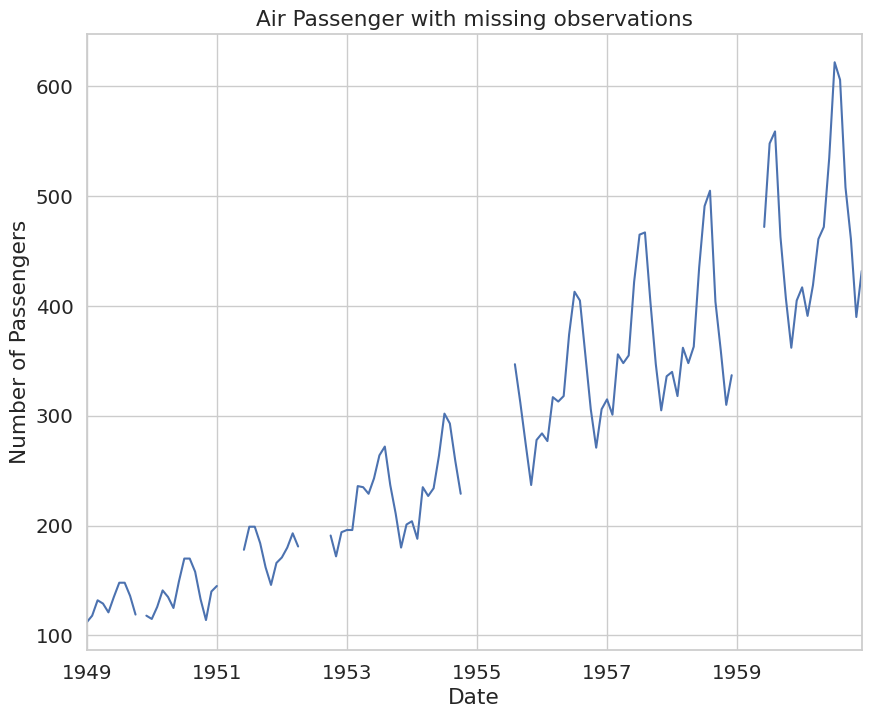

In [9]:
ax = data.plot(legend=None, figsize=(10,8))
ax.set_title('Air Passenger with missing observations')
ax.set_ylabel('Number of Passengers')
ax.set_xlabel('Date')

----

## Missing value handling

I will show 5 techniques for missing value handling.
- Forward fill method (Last observation carried forward)
- Backward fill method (Next observation carried backwards)
- Linear interpolation
- Spline interpolation
- Seasonal decomposition and interpolation

In [10]:
ffm = data.copy()
bfm = data.copy()
li = data.copy()
si = data.copy()
sdi = data.copy()

----

### Forward fill method

As the name implies, here the missing data points are filled with the value of the last known data point. 

Text(0.5, 0, 'Date')

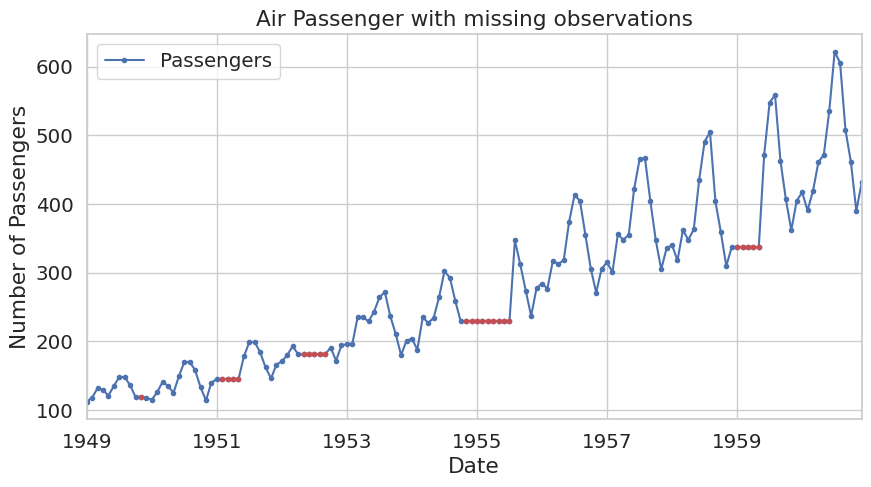

In [11]:
ffm_imputed = ffm.fillna(method='ffill')
ax = ffm_imputed.plot(linestyle="-", marker=".", figsize=[10, 5])
ffm_imputed[ffm.isnull()].plot(ax=ax, legend=None, marker=".", color="r")
ax.set_title('Air Passenger with missing observations')
ax.set_ylabel('Number of Passengers')
ax.set_xlabel('Date')

----

### Backward fill method

Same like forward fill method, but this time the missing values will be filled with the next known observation. 

Text(0.5, 0, 'Date')

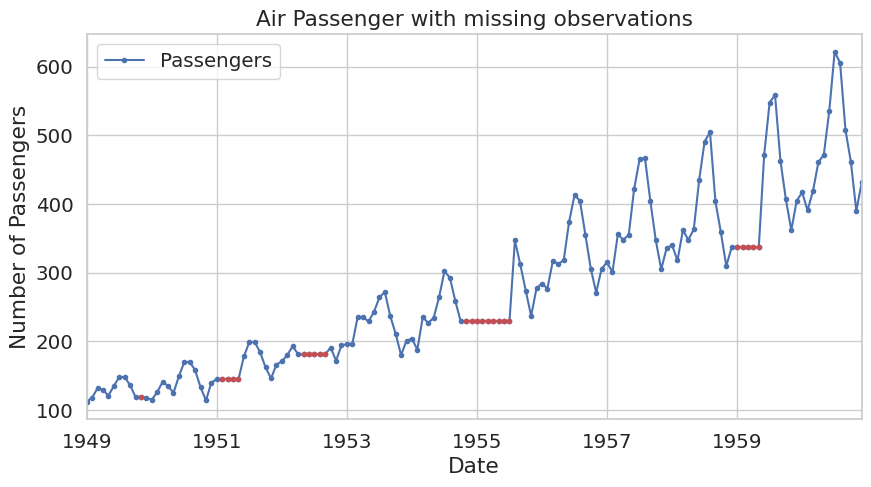

In [12]:
bfm_imputed = bfm.fillna(method='ffill')
ax = bfm_imputed.plot(linestyle="-", marker=".", figsize=[10, 5])
bfm_imputed[bfm.isnull()].plot(ax=ax, legend=None, marker=".", color="r")
ax.set_title('Air Passenger with missing observations')
ax.set_ylabel('Number of Passengers')
ax.set_xlabel('Date')

As we see in the above plots both methods can distort important structures of the time series (e.g. the shape of the seasonal component) depending on how large the gaps of missing data are. If these gaps are small the distortions are small, if the gaps are large then the distortions are also large. 

The distortions to the time series created by data imputation can negatively impact the fitting of a model. If the proportion of missing data is small then the impact of these distortions on the fitting of a model should be less and may be tolerable depending on the use case.

One minor advantage of forward filling over backward filling is that is does not leak any data from the future to the imputed observations. 

If a dataset has missing data with small gap sizes then the forward filling method would be a sufficient method to impute missing data without distorting the time series too heavily and ensuring no data leakage is occurring. Since we have a big gape size arounnd 1953, 1955 and 1959 we have to search for a better alternative. 

----

### Linear interpolation

Linear interpolation in time series refers to a method of estimating missing values or filling in gaps in a time series data by assuming a linear relationship between the available data points. It assumes that the values between the known data points change linearly over time. 

Text(0.5, 0, 'Date')

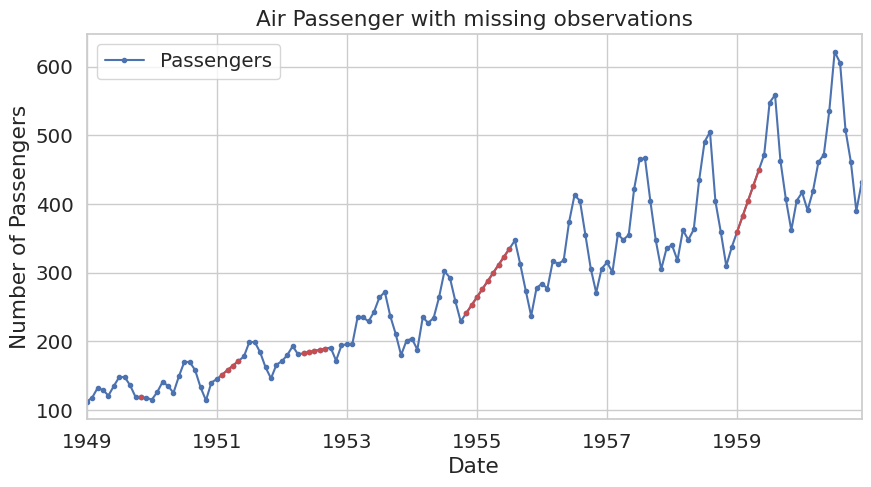

In [13]:
li_imputed = li.interpolate(method='linear')
ax = li_imputed.plot(linestyle="-", marker=".", figsize=[10, 5])
li_imputed[li.isnull()].plot(ax=ax, legend=None, marker=".", color="r")
ax.set_title('Air Passenger with missing observations')
ax.set_ylabel('Number of Passengers')
ax.set_xlabel('Date')

In the above plot we can see that linear interpolation is reasonable for small gaps but also captures the trend for larger gaps. However, the seasonality is lost. 

----

### Spline interpolation

Spline interpolation is used to estimate missing values or fill gaps in a time series data by fitting a smooth curve or spline to the available data points. It ais to capture the underlying pattern of the data more accurately by using a piecewise polynomial function. 

Spline interpolation offers several advantages over linear interpolation in time series:

- It can capture more complex and non-linear patterns in the data, as cubic splines can represent a wider range of curves.
- Spline interpolation produces a smoother curve without sharp edges, resulting in a more visually appealing representation.
- It reduces the risk of overfitting compared to higher-degree polynomial interpolation.

However, spline interpolation can be computationally more intensive and may require more data points to achieve accurate estimates. Additionally, the choice of spline interpolation method, such as cubic or higher-degree splines, may depend on the characteristics of the data and the desired smoothness.

Overall, spline interpolation is a flexible and effective technique for estimating missing values or filling gaps in time series data, providing a more accurate representation of the underlying patterns and dynamics.

Text(0.5, 0, 'Date')

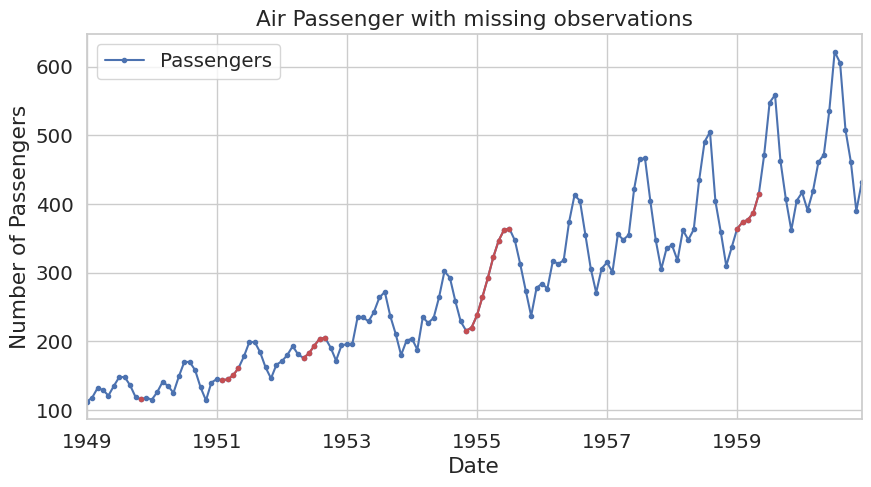

In [14]:
si_imputed = si.interpolate(method='spline', order=3)
ax = si_imputed.plot(linestyle="-", marker=".", figsize=[10, 5])
si_imputed[si.isnull()].plot(ax=ax, legend=None, marker=".", color="r")
ax.set_title('Air Passenger with missing observations')
ax.set_ylabel('Number of Passengers')
ax.set_xlabel('Date')

----

### Seasonal decomposition and interpolation

This method involves estimating the seasonal component of a time series. This is then subtracted from the original time series to provide a de-seasoned time series. Any of the prior interpolation methods can then be used on the de-seasoned time series and the seasonal component can be added back to the de-seasoned time series.

There are many different methods to decompose a time series into seasonal and other components. We shall use STL for this notebook. n advantage of STL is that it is able to estimate a seasonal component which can change over time (e.g., if the amplitude or frequency of the seasonal component changes).


In [15]:
from statsmodels.tsa.seasonal import STL

STL can't handle missing data. A linear interpolation is typically used to fill missing data before decomposing the time series using STL.

In [16]:
res = STL(sdi.interpolate(method="linear"), seasonal=31).fit()

The seasonal parameter determines how much data is used to infer the seasonality at any given point. If the seasonal component is thought to be fixed throughout time then a large seasonal parameter can be set so that more data is used to determine the seasonal component. Likewise if the seasonal component is thought to change (e.g., the frequency) quickly over time the seasonal parameter can be reduced so that only recent data contributes to determining the seasonal component.

The large missing gap is linearly interpolated. This means that the algorithm sees a region of data with no seasonal component and could distort the estimation of the seasonal component. A large seasonal parameter is set to overcome this. This works because a larger portion of the data is now used to estimate the seasonal component meaning that the local distortion from the interpolation has less effect.

We now plot the decomposition to inspect that it is reasonable.

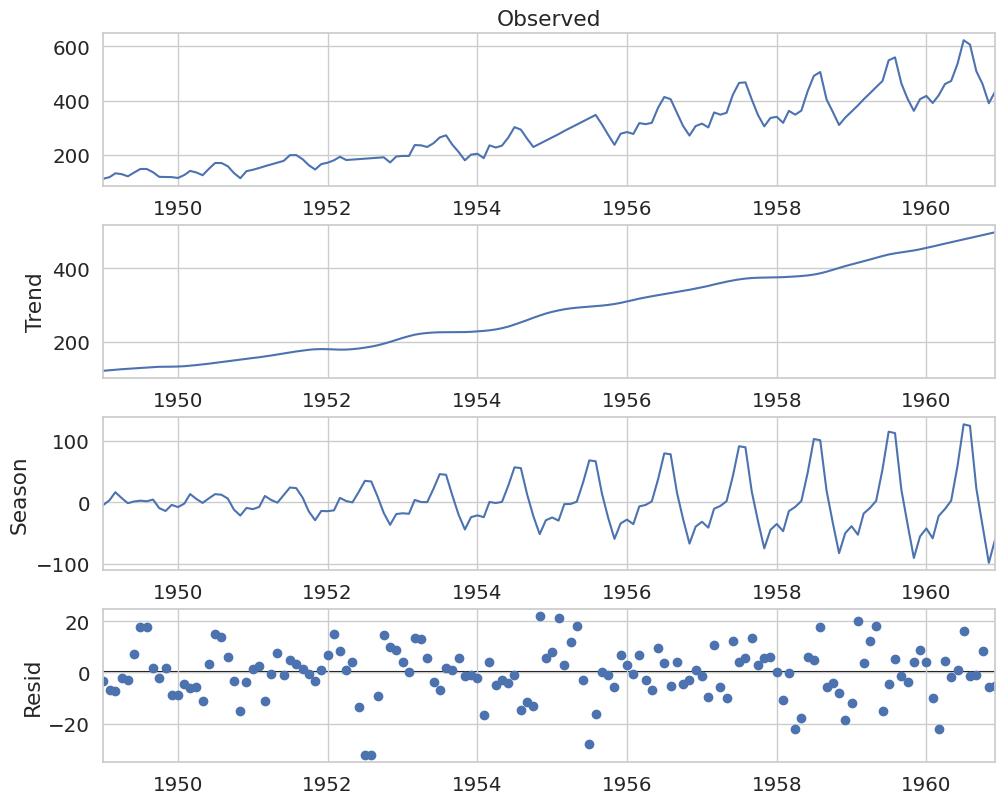

In [17]:
plt.rc("figure", figsize=(10, 8))
plt.rc("font", size=5)
res.plot();

We now:

1. extract the seasonal component
2. de-seasonalise the original time series
3. perform linear interpolation on the de-seasonalised data
4. Add the seasonal component back to the imputed de-seasonalised data

In [18]:
seasonal_component = res.seasonal
seasonal_component.head()

Month
1949-01-01    -4.732242
1949-02-01     3.324701
1949-03-01    16.248299
1949-04-01     6.673724
1949-05-01    -1.617146
Name: season, dtype: float64

Text(0.5, 0, 'Date')

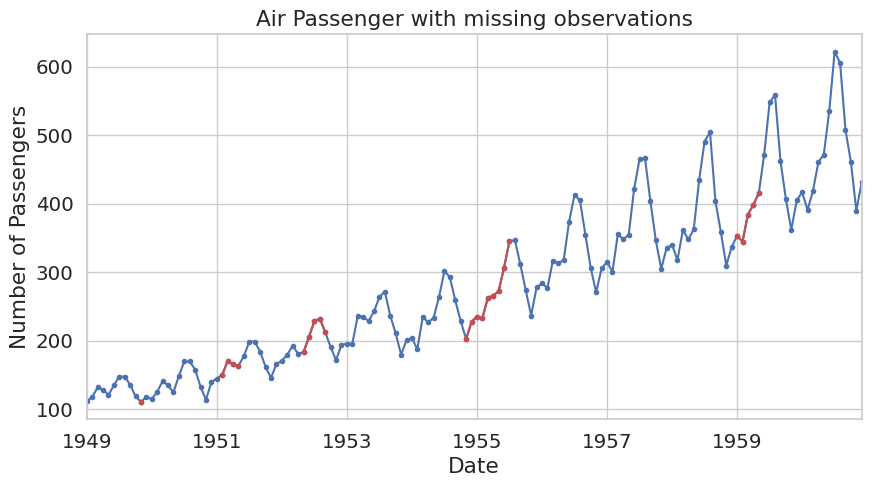

In [19]:
sdi_deseasonalised = sdi['Passengers'] - seasonal_component
sdi_deseasonalised_imputed = sdi_deseasonalised.interpolate(method="linear")
sdi_imputed = sdi_deseasonalised_imputed + seasonal_component
sdi_imputed = sdi_imputed.to_frame().rename(columns={0: 'Passengers'})
ax = sdi_imputed.plot(linestyle="-", marker=".", figsize=[10, 5], legend=None)
ax = sdi_imputed[sdi.isnull()].plot(ax=ax, legend=None, marker=".", color="r")
ax.set_title('Air Passenger with missing observations')
ax.set_ylabel('Number of Passengers')
ax.set_xlabel('Date')

Simpler seasonal decompositions methods exist in Statsmodels such as seasonal_decompose. However, the simplicity of the seasonal_decompose method has drawbacks which may or may not be relevant for your use case (e.g., naive seasonal decomposition methods may not capture seasonality which changes over time, may not return values at the start and end of a time series etc.). STL is a more advanced method that is commonly used for data imputation.

----

### Wrap up

Now let´s wrap up the missing value section and plot the result of each technique in on plot to choose the best fit. 

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
original.plot(ax=ax, color='blue', label='Original')
bfm_imputed.plot(ax=ax, color='black', label='FFM/BFM')
li_imputed.plot(ax=ax, color='brown', label='Linear interpolation')
si_imputed.plot(ax=ax, color='red', label='Spline interpolation')
sdi_imputed.plot(ax=ax, color='yellow', label='Seasonal decomposition and interpolation')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of Passengers', fontsize=15)
plt.title('Compare different missing values fill techniques', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=15)
ax.legend(['Original', 'FFM/BFM', 'Linear interpolation', 'Spline interpolation', 'Seasonal decomposition and interpolation'], fontsize=15);
plt.show()

I guess that the yellow line fits the original dataset the best. So we use seasonal decomposition and interpolation as our technique to go on. 

----

## Time series features

Since we do not have any features to run the prediction, let´s extract date features from our `Date` index. 

In [ ]:
data = sdi_imputed.copy()
data.reset_index(inplace=True)
data = data.rename(columns={'Month': 'Date'})

In [ ]:
data['Year'] = data.Date.dt.year
data['Month'] = data.Date.dt.month
data['Quarter'] = data.Date.dt.quarter
data['LeapYear'] = data.Date.dt.is_leap_year

Now we have at least a view additional columns to work with. Let´s check if we can find some relationship between the variables. 

----

## Exploratory Data Analysis

Text(0.5, 1.0, 'Passengers per Year')

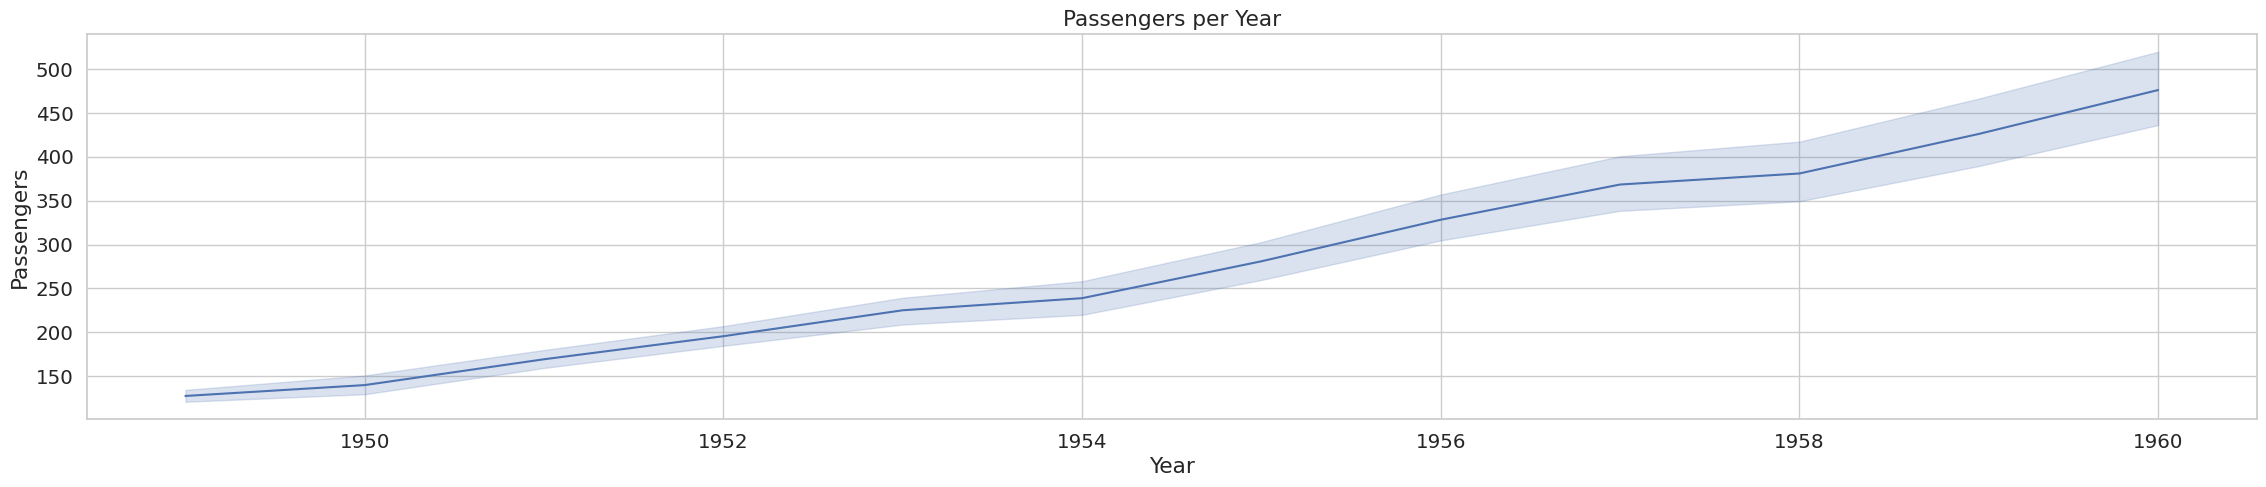

In [23]:
fig, ax = plt.subplots(figsize=(28, 5))
sns.lineplot(data=data, x='Year', y='Passengers', ax=ax)
ax.set_title('Passengers per Year')

Text(0.5, 1.0, 'Passengers per Month')

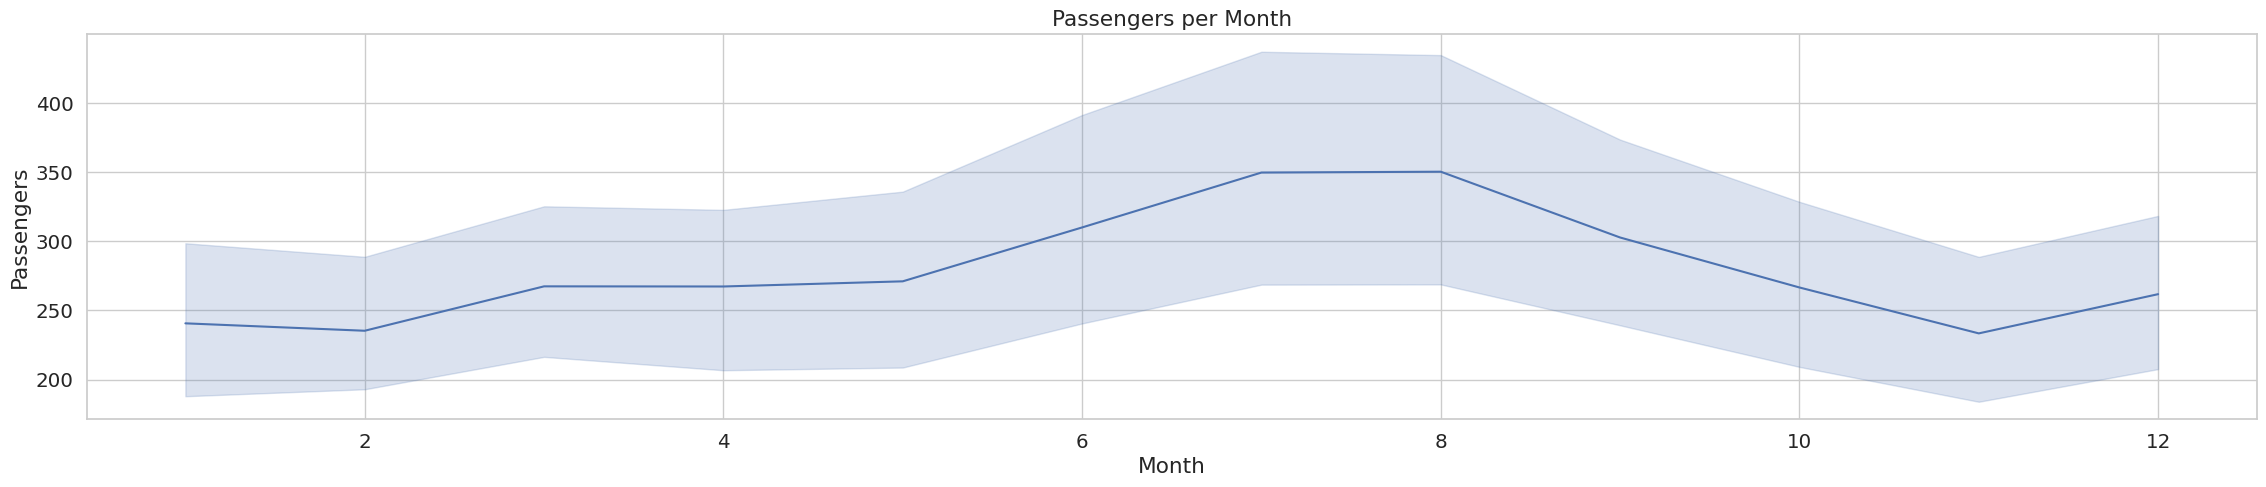

In [24]:
fig, ax = plt.subplots(figsize=(28, 5))
sns.lineplot(data=data, x='Month', y='Passengers', ax=ax)
ax.set_title('Passengers per Month')

Text(0.5, 1.0, 'Passengers per Quarter')

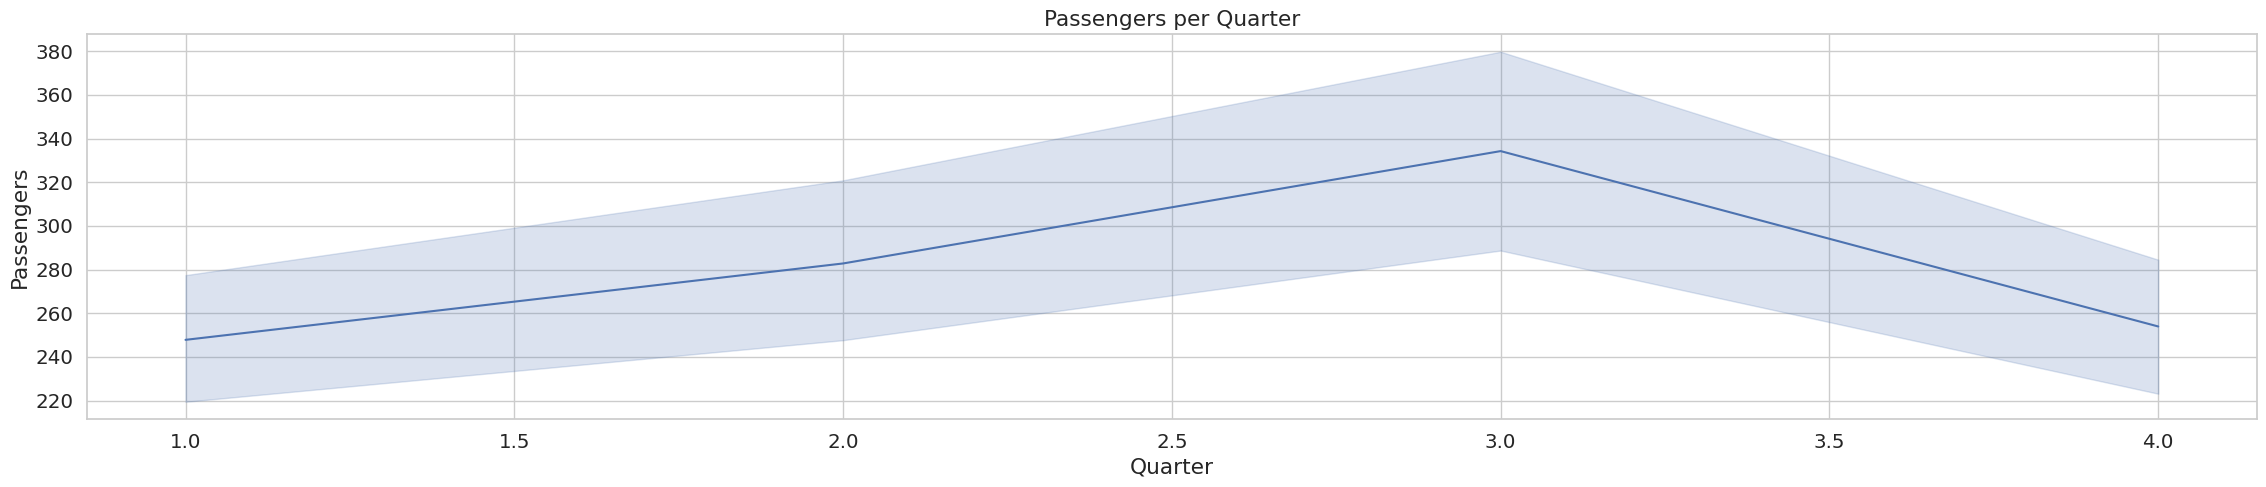

In [25]:
fig, ax = plt.subplots(figsize=(28, 5))
sns.lineplot(data=data, x='Quarter', y='Passengers', ax=ax)
ax.set_title('Passengers per Quarter')

As we can see, we have a increasing yearly trend as well as some seasonality in the `Month` and `Quarter` variables. 

<AxesSubplot: xlabel='Passengers', ylabel='Density'>

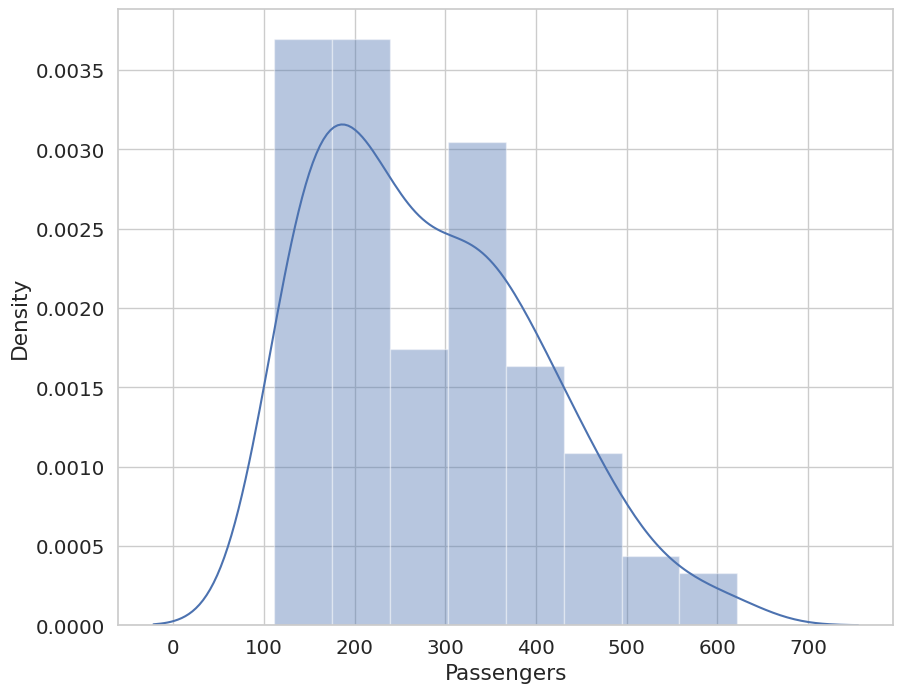

In [26]:
sns.distplot(data['Passengers'])

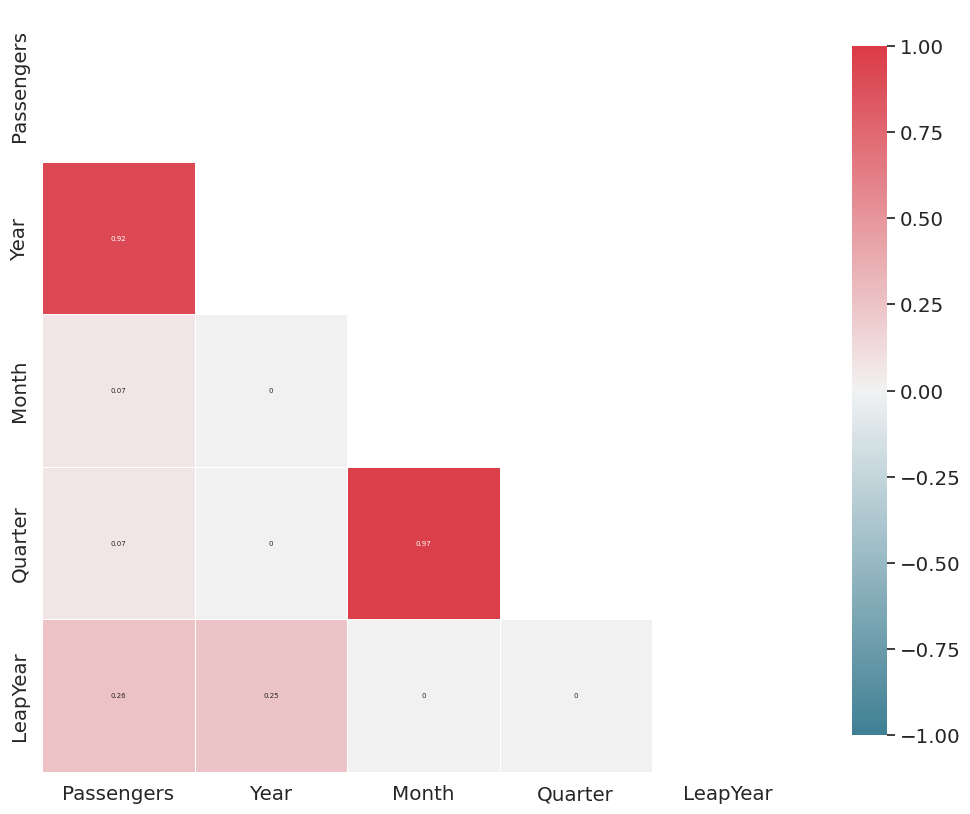

In [27]:
corr = data.corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.7}, annot=True)
plt.tight_layout()

In [ ]:
no_missing_vals = data['Passengers'].isnull().sum()
print(f'No of missing observations: {no_missing_vals}')

No of missing observations: 0


----

## Modeling

Okay and now let´s train a LightGBM model to predict the last 2 years. 
First drop our target from our feature dataframe. 

In [ ]:
train = data.loc[data['Year'] < 1959]
test = data.loc[data['Year'] >= 1959]

In [ ]:
print(f'Train size: {len(train)}')
print(f'Test size: {len(test)}')

Train size: 120
Test size: 24


In [ ]:
y_train = train['Passengers']
y_test = test['Passengers']
test_dates = test['Date']
X_train = train.drop(columns=['Date', 'Passengers'])
X_test = test.drop(columns=['Date', 'Passengers'])

In [ ]:
print(X_train.shape)
print(X_test.shape)

(120, 4)
(24, 4)


In [ ]:
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 15,
    'max_depth': 3,
    'learning_rate': 0.1,
    'metric': {'l2','l1'},
    'verbose': -1
}

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [ ]:
model = lgb.train(params,
                 num_boost_round=300,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=20)

[1]	valid_0's l1: 192.811	valid_0's l2: 42880.6
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l1: 181.171	valid_0's l2: 38527.7
[3]	valid_0's l1: 170.696	valid_0's l2: 34841.6
[4]	valid_0's l1: 163.825	valid_0's l2: 32352.6
[5]	valid_0's l1: 155.999	valid_0's l2: 29849.6
[6]	valid_0's l1: 148.955	valid_0's l2: 27701.7
[7]	valid_0's l1: 142.616	valid_0's l2: 25853.4
[8]	valid_0's l1: 138.025	valid_0's l2: 24404.6
[9]	valid_0's l1: 132.779	valid_0's l2: 22983.9
[10]	valid_0's l1: 128.057	valid_0's l2: 21752.4
[11]	valid_0's l1: 123.808	valid_0's l2: 20682.1
[12]	valid_0's l1: 120.736	valid_0's l2: 19795.7
[13]	valid_0's l1: 117.219	valid_0's l2: 18958.8
[14]	valid_0's l1: 114.053	valid_0's l2: 18226.7
[15]	valid_0's l1: 110.289	valid_0's l2: 17382.3
[16]	valid_0's l1: 106.902	valid_0's l2: 16646.6
[17]	valid_0's l1: 105.319	valid_0's l2: 15969.7
[18]	valid_0's l1: 103.096	valid_0's l2: 15506.4
[19]	valid_0's l1: 100.428	valid_0's l2: 14963.4
[20]	valid_0's l1

In [ ]:
y_preds = model.predict(X_test)

In [ ]:
print(f'MAE: {mean_absolute_error(y_test, y_preds)}')
print(f'MSE: {mean_squared_error(y_test, y_preds)}')
print(f'RMSE: {mean_squared_error(y_test, y_preds, squared=False)}')

MAE: 74.93650099934847
MSE: 7268.122496639556
RMSE: 85.25328437450112


The base model reaches a MAE about 74. This is semi okay, lets plot the prediction against the real values. 

In [ ]:
test_dates = pd.DataFrame(test_dates, columns=['Date']).reset_index(drop=True)
y_test = pd.DataFrame(y_test, columns=['Passengers']).reset_index(drop=True)
y_preds = pd.DataFrame(y_preds, columns=['Pred_Passengers']).reset_index(drop=True)

In [ ]:
pred_df = pd.concat([test_dates, y_test, y_preds], axis=1)

Text(0.5, 1.0, 'Real vs. Prediction')

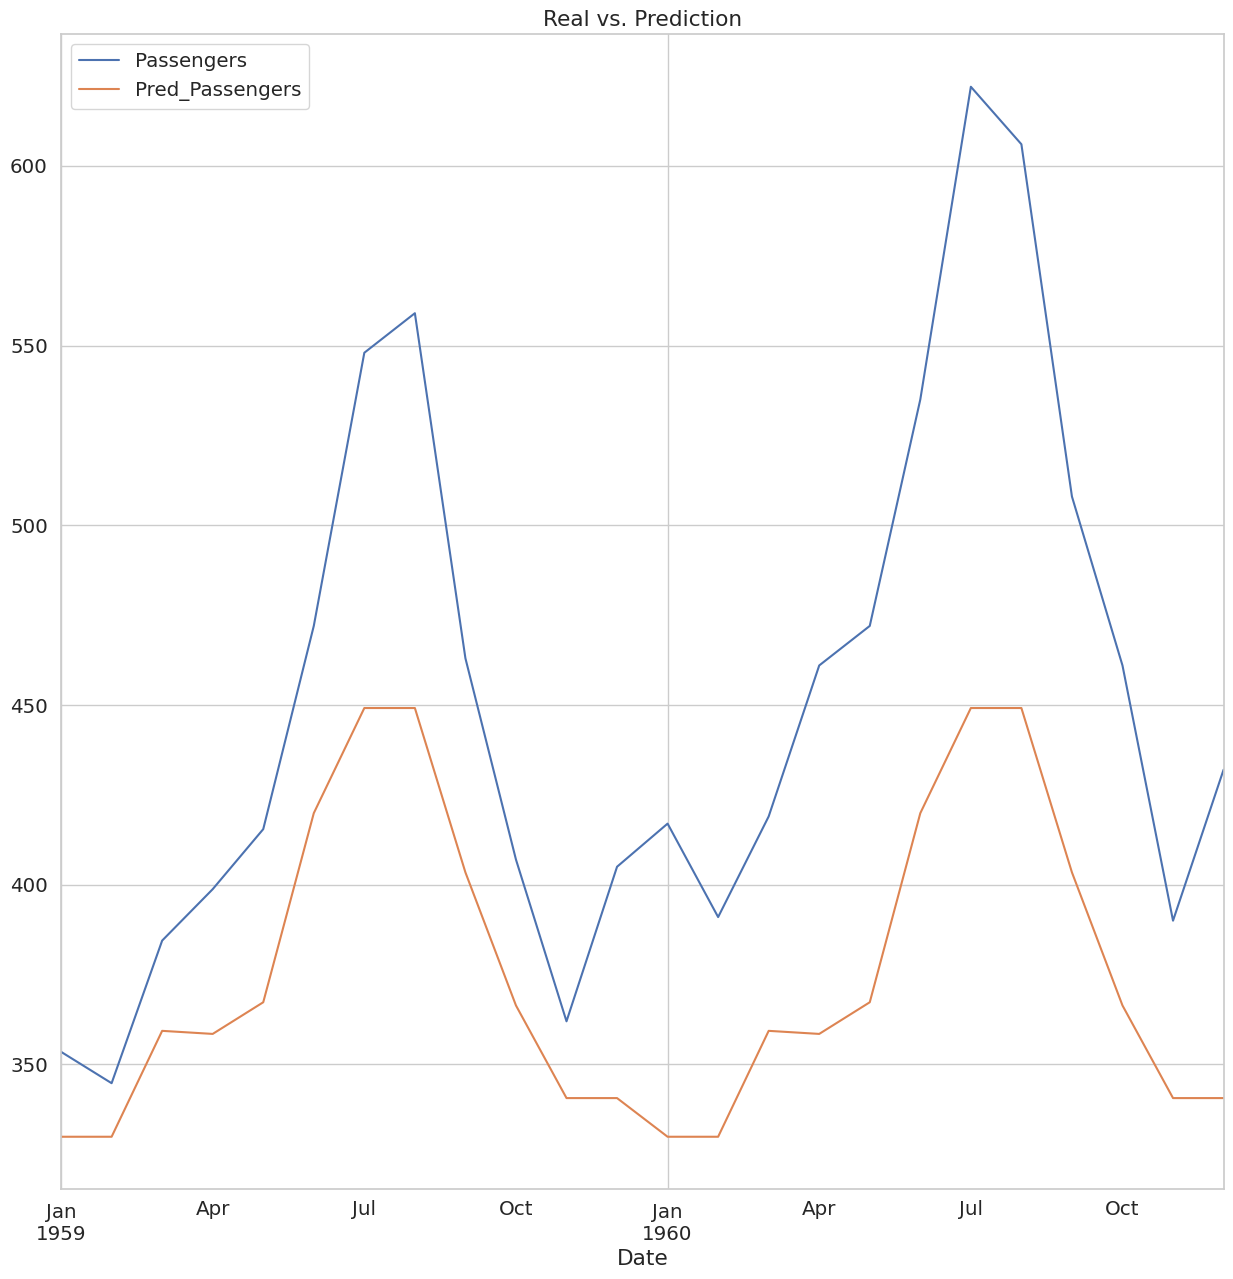

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
pred_df.plot(ax=ax, x='Date', y='Passengers')
pred_df.plot(ax=ax, x='Date', y='Pred_Passengers')
ax.set_title('Real vs. Prediction')

I will not spend too much time in modeling. There are several approaches to generate more features, e.g. lag-features, rolling-means etc. 
I guess the model will learn better if more meaningful features were given. 

The main purpose in this notebook was to provide several easy techniques to fill missing values within time series.